# XGBoost Classification

In [1]:
!pip3 install xgboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import copy
import torch
from typing import Dict
import numpy as np
from sklearn.decomposition import PCA
from threadpoolctl import threadpool_limits
import pickle

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


def plot_confusion_matrix(cf_matrix, classes, cm_path, figsize=(6,6), cmap="Blues", ax=None, counts_zero=True):
    """Generates and saves a confusion matrix plot to a file.""" 

    cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    
    if counts_zero:
        perc_labs = ["{0:.1%}".format(value) for value in cmn.flatten()]
        group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
    else:
        perc_labs = ["{0:.1%}".format(value) if value > 0 else "0%" for value in cmn.flatten()]
        group_counts = ["{0:0.0f}\n".format(value) if value > 0 else "" for value in cf_matrix.flatten()]
        
    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,perc_labs)]
    box_labels = np.asarray(box_labels).reshape(cmn.shape[0],cmn.shape[1])
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(cmn, annot=box_labels, fmt='', 
                annot_kws={"fontsize":12},
                xticklabels=classes, 
                yticklabels=classes,
            cmap=cmap,
            linecolor='lightgray', linewidths=0.5,
            square=True,
            cbar=False,
            vmin=0, vmax=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.show()
    plt.close()

In [13]:
cmaps = {
     'P1': 'Blues',
     'P2': 'Greens',
     'P3': 'Purples',
     'P4': 'Oranges',
     'P5': 'Reds',
     'P6': 'Greys',
}

In [14]:
classes = {
    'ADM': 1,
    'BLD': 2,
    'CFG': 3,
    'CUST': 4,
    'DEV': 5,
    'DOC': 6,
    'EDU': 7,
    'MIGR': 8,
    'MIT': 9,
    'PM': 10,
    'RQM': 11,
    'RVW': 12,
    'TST': 13,
    'BUG': 14
}

In [15]:
Issues = {
     'P1': 'P1-g4-c-emb',
     'P2': 'P2-g4-c-emb',
     'P3': 'P3-g4-c-emb',
     'P4': 'P4-g4-c-emb',
     'P5': 'P5-g4-c-emb',
     'P6': 'P6-g4-c-emb',
}


datasets ={
    'Issues': Issues, 
}

datasets_path = "../Data" ## DATA NOT PUBLISHED DUE TO CONFIDENTIONALITY RESTRICTIONS

In [16]:
# we shall be able to randomly choose seeds but they should be stored so we can replicate the evaluation 
# these are random seeds per run
seeds = [2324, 343, 1232, 4343, 434343, 4343, 135, 343, 16, 999343]

In [17]:
def count_classes(df, count):
    for class_key in classes.keys():
        class_count = df['class_name'].value_counts().get(class_key)
        count[class_key] = class_count if class_count is not None else 0
        
base_path = f"{datasets_path}/base-c-emb.csv"
base_df = pd.read_csv(base_path, sep='$', low_memory=False)
base_count = dict()
count_classes(base_df, base_count)

In [19]:
base_df.shape

(91145, 2073)

In [86]:
pd.options.mode.chained_assignment = None  # default='warn'

from warnings import simplefilter
from sklearn.exceptions import UndefinedMetricWarning
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UndefinedMetricWarning)
simplefilter(action='ignore', category=UserWarning)


result = {}
runs = 10
folds = 10
use_base = True
use_pca = False
max_fill_missing_perc = 1
use_sample_weights = True

for dataset_name in datasets:
    dataset = datasets[dataset_name]
    for project, repo in list(dataset.items()):
        print(f"Starting validation for project {project}...")
        data_path = f"{datasets_path}/{repo}.csv"
        print(f'- loading features from file "{data_path}"')
        p_emb_df = pd.read_csv(data_path, sep='$')
        p_emb_df = p_emb_df[(p_emb_df["class_value"].notnull()) & (p_emb_df["class_value"] != 0)]
        
        project_classes = p_emb_df['class_name'].unique()
        
        if use_base:
            emb_count = dict()
            count_classes(p_emb_df, emb_count)
            max_count = int(max([v for k, v in emb_count.items()]) * max_fill_missing_perc)
            transfer_df = pd.DataFrame()
            for class_key in project_classes:
                defficiency = max_count - emb_count[class_key]
                if defficiency > 0:
                    class_df = base_df.loc[base_df['class_name'] == class_key].sample(min(base_count[class_key], defficiency))
                    transfer_df = pd.concat([transfer_df, class_df])
            emb_count2 = dict()
            count_classes(p_emb_df, emb_count2)
        
        X = p_emb_df
        class_mappings = X[['class_value', 'class_name']].drop_duplicates().sort_values("class_value").set_index("class_value").to_dict()['class_name']
        y = copy.deepcopy(X["class_value"].astype('int64'))
        X.drop(['id', 'class_name', 'class_value', 'contents'], axis='columns', inplace=True)
        
        if use_base:
            missing_cols = set(X.columns.tolist()) - set(transfer_df.columns.tolist())
            for miss_col in missing_cols:
                transfer_df[miss_col] = [0] * transfer_df.shape[0]
            transfer_X = transfer_df.copy()[X.columns]
            transfer_y = transfer_df["class_value"].copy().astype('int64')
        
        project_results = dict(acc=[], rec=[], prec=[],fscore=[], mcc=[], cnf=[], n=X.shape[0], class_mappings=class_mappings)
        
        for run in range(runs):
            kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seeds[run])
            print(f'- run {run+1} / {runs}')
            cv_preds = []
            cv_trues = []
            print('-- fold: ', end="\n")
            fold = 1
            for train_index, val_index in kfold.split(X, y):
                
                model = XGBClassifier(500, max_depth=3, objective="multi:softmax", device="gpu")
                le = LabelEncoder()
                
                print(f'{fold}', end=' ')
                X_train = X.iloc[train_index]
                X_test = X.iloc[val_index]
                y_train = y.iloc[train_index]
                
                if use_base:
                    X_train = pd.concat([X_train, transfer_X])
                    y_train = pd.concat([y_train, transfer_y])
                
                if use_pca:
                    with threadpool_limits(limits=1):
                        pca = PCA(n_components=128)
                        emb_columns = X_train.loc[:,X_train.columns.str.startswith("emb")].columns.tolist()
                        X_train_emb = pd.DataFrame(pca.fit_transform(X_train[emb_columns]))
                        X_test_emb = pd.DataFrame(pca.transform(X_test[emb_columns]))
                        X_train.drop(emb_columns, axis=1, inplace=True)
                        X_test.drop(emb_columns, axis=1, inplace=True)
                        X_train = pd.concat([X_train.reset_index(drop=True), X_train_emb.reset_index(drop=True)], axis=1)
                        X_test = pd.concat([X_test.reset_index(drop=True), X_test_emb.reset_index(drop=True)], axis=1)

                        print(f"PCA variance explained for embeddings {sum(pca.explained_variance_ratio_)}")

                y_train = le.fit_transform(y_train)
                if use_sample_weights:
                    model.fit(X_train, y_train, sample_weight=compute_sample_weight("balanced", y_train))
                else:
                    model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred = le.inverse_transform(y_pred)

                cv_preds += y_pred.tolist()
                cv_trues += y.iloc[val_index].tolist()
                fold += 1
            print("")
            project_results['acc'].append(accuracy_score(cv_trues, cv_preds))
            project_results['rec'].append(recall_score(cv_trues, cv_preds, average="macro"))
            project_results['prec'].append(precision_score(cv_trues, cv_preds, average="macro"))
            project_results['fscore'].append(f1_score(cv_trues, cv_preds, average="macro"))
            project_results['mcc'].append(mcc(cv_trues, cv_preds))
            project_results['cnf'].append(confusion_matrix(cv_trues, cv_preds))

                
        result[project] = project_results



Starting validation for project P1...
- loading features from file "../py-ccflex/temp/processing/P1-g4-c-emb.csv"
- run 1 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 2 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 3 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 4 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 5 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 6 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 7 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 8 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 9 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 10 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
Starting validation for project P2...
- loading features from file "../py-ccflex/temp/processing/P2-g4-c-emb.csv"
- run 1 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 2 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 3 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 4 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 5 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 6 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 7 / 10
-- fold: 
1 2 3 4 5 6 7 8 9 10 
- run 

In [76]:
result

{'P1': {'acc': [0.9113389626055488,
   0.9134499396863691,
   0.9122436670687576,
   0.9155609167671894,
   0.9134499396863691,
   0.9155609167671894,
   0.908021712907117,
   0.9134499396863691,
   0.9131483715319663,
   0.911037394451146],
  'rec': [0.5476215122229207,
   0.56110379196416,
   0.5463848919211259,
   0.5571729822958448,
   0.5493394711675588,
   0.5571729822958448,
   0.5425925518668666,
   0.56110379196416,
   0.5324415503082865,
   0.5426707767810655],
  'prec': [0.6734326507422701,
   0.721124121963486,
   0.6860675382457769,
   0.7657991991797765,
   0.7797158896599258,
   0.7657991991797765,
   0.7260161033870111,
   0.721124121963486,
   0.6645207098140524,
   0.657940959640997],
  'fscore': [0.5828791312337872,
   0.6003014724312337,
   0.5817646380940873,
   0.6027933002281404,
   0.5913522388568369,
   0.6027933002281404,
   0.5824485745741314,
   0.6003014724312337,
   0.5603411061784751,
   0.5744426043717089],
  'mcc': [0.8928688369892773,
   0.895158493390

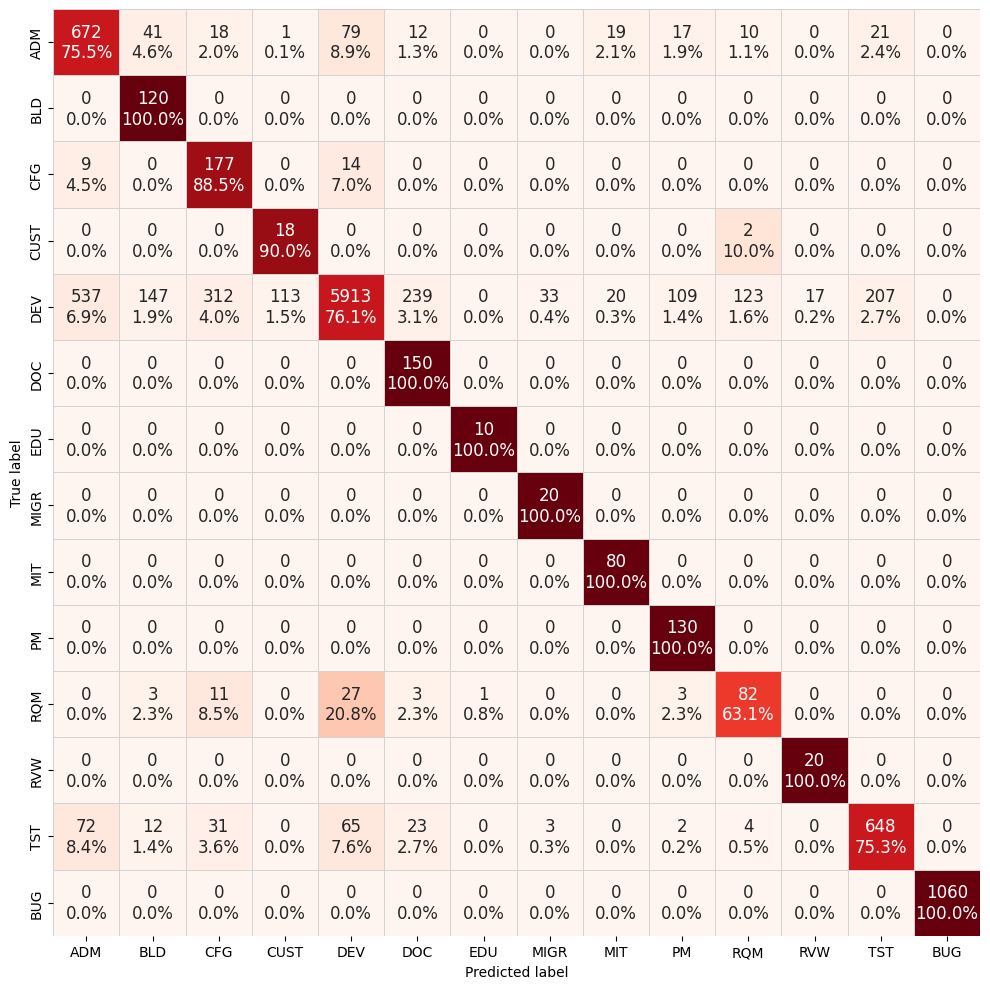

In [105]:
project = "P5"
cnf_matrix = sum(result[project]['cnf'])
plot_confusion_matrix(cnf_matrix, classes=[v for k,v in result[project]['class_mappings'].items()], 
                      cm_path=f"{project}-cnf.pdf", figsize=(10,10), cmap=cmaps[project])

In [ ]:
## RUN THE CODE ABOVE WITH DIFFERENT PARAMETERS AND SAVE

In [89]:
with open('yes-db-no-pca-xgboost-500-3-mxbai.pickle', 'wb') as f:
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)


In [32]:
with open('yes-db-no-pca-xgboost-500-3-mxbai.pickle', 'rb') as f:
    result = pickle.load(f)

In [ ]:
import pickle
with open('no-db-no-pca-xgboost-500-3-mxbai.pickle', 'wb') as f:
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)

In [294]:
with open('no-db-no-pca-xgboost-500-3-mxbai.pickle', 'rb') as f:
    result = pickle.load(f)

## Analysis

In [6]:
class_counts_df = pd.DataFrame()

for dataset_name in datasets:
    dataset = datasets[dataset_name]
    for project, repo in list(dataset.items()):
        print(f"Starting validation for project {project}...")
        data_path = f"{datasets_path}/{repo}.csv"
        print(f'- loading features from file "{data_path}"')
        p_emb_df = pd.read_csv(data_path, sep='$')
        p_emb_df = p_emb_df[(p_emb_df["class_value"].notnull()) & (p_emb_df["class_value"] != 0)]
        
        project_df = pd.DataFrame({"Project":[project]*p_emb_df.shape[0], "Category": p_emb_df['class_name']})
        
        class_counts_df = pd.concat([class_counts_df, project_df])
        
        

Starting validation for project P1...
- loading features from file "../Data/P1-g4-c-emb.csv"
Starting validation for project P2...
- loading features from file "../Data/P2-g4-c-emb.csv"
Starting validation for project P3...
- loading features from file "../Data/P3-g4-c-emb.csv"
Starting validation for project P4...
- loading features from file "../Data/P4-g4-c-emb.csv"
Starting validation for project P5...
- loading features from file "../Data/P5-g4-c-emb.csv"
Starting validation for project P6...
- loading features from file "../Data/P6-g4-c-emb.csv"


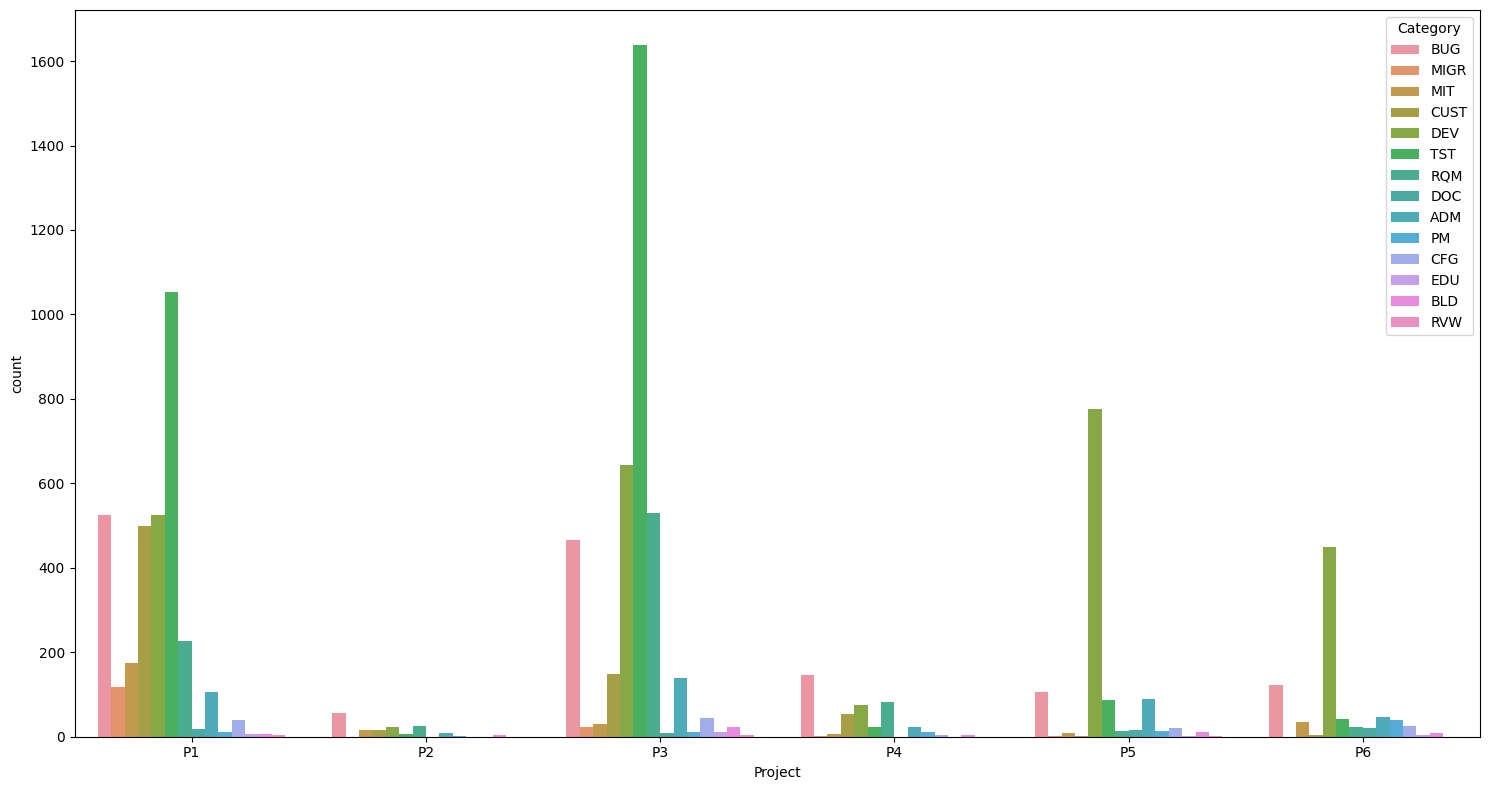

In [129]:
figsize=(15,8)

fig, ax = plt.subplots(figsize=figsize)

sns.countplot(hue ='Category', x="Project", data = class_counts_df)
 
plt.tight_layout()
plt.show()
plt.close()

/tmp/ipykernel_21979/815596016.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])


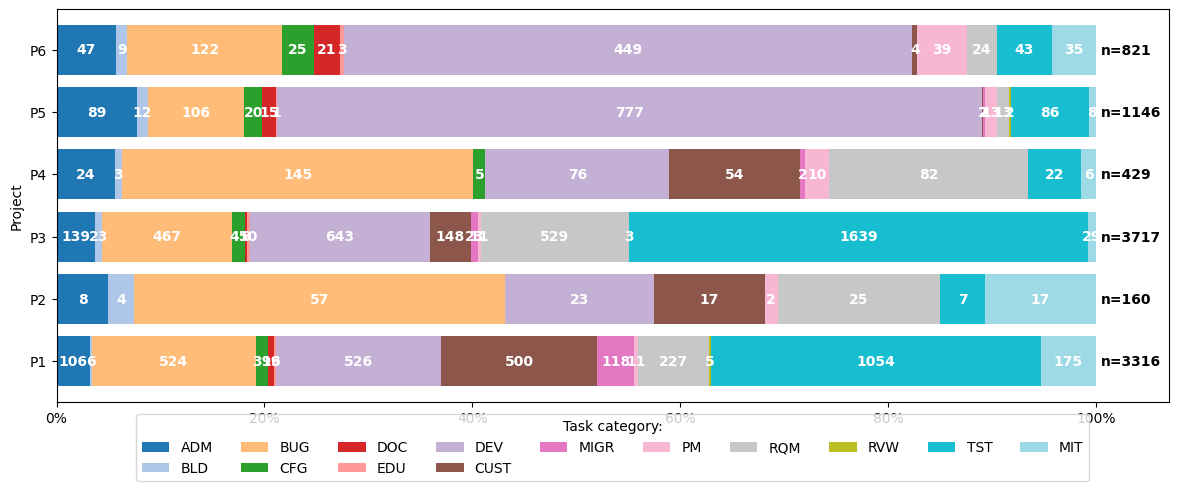

In [10]:
figsize=(12,5)
fig, ax = plt.subplots(figsize=figsize)

cat_ord = ['ADM',
 'BLD',
 'BUG',
 'CFG',
 'DOC',
  'EDU',          
 'DEV',
 'CUST',
 'MIGR',
 'PM',
 'RQM',
 'RVW',
 'TST',
 'MIT',
]


group = class_counts_df.groupby(['Project', 'Category']).size().unstack()[cat_ord]

group.apply(lambda x:x/x.sum(), axis=1).plot(kind='barh', stacked=True, legend=True, ax=ax, cmap="tab20", width=0.80)

ax.set_xticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22), title="Task category:", ncol=10, shadow=False, fancybox=True)

labels = [f'{int(i)}' if i > 0 else "" for i in group.apply(lambda x:x, axis=1).to_numpy().flatten(order='F')]


for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height() / 2 
    ax.annotate(labels[i], (x, y), ha='center', va='center', c='white', weight="bold")

    
rects = ax.patches
box_labels = class_counts_df.groupby(['Project']).size().tolist()

ax.set_xlim(0, 1.07)

for i, total in enumerate(box_labels):
    ax.text(1.005, i - 0.07 ,f"n={total}", ha='left', weight='bold')

plt.tight_layout()
plt.savefig("categories-counts-projects.pdf")
plt.show()
plt.close()

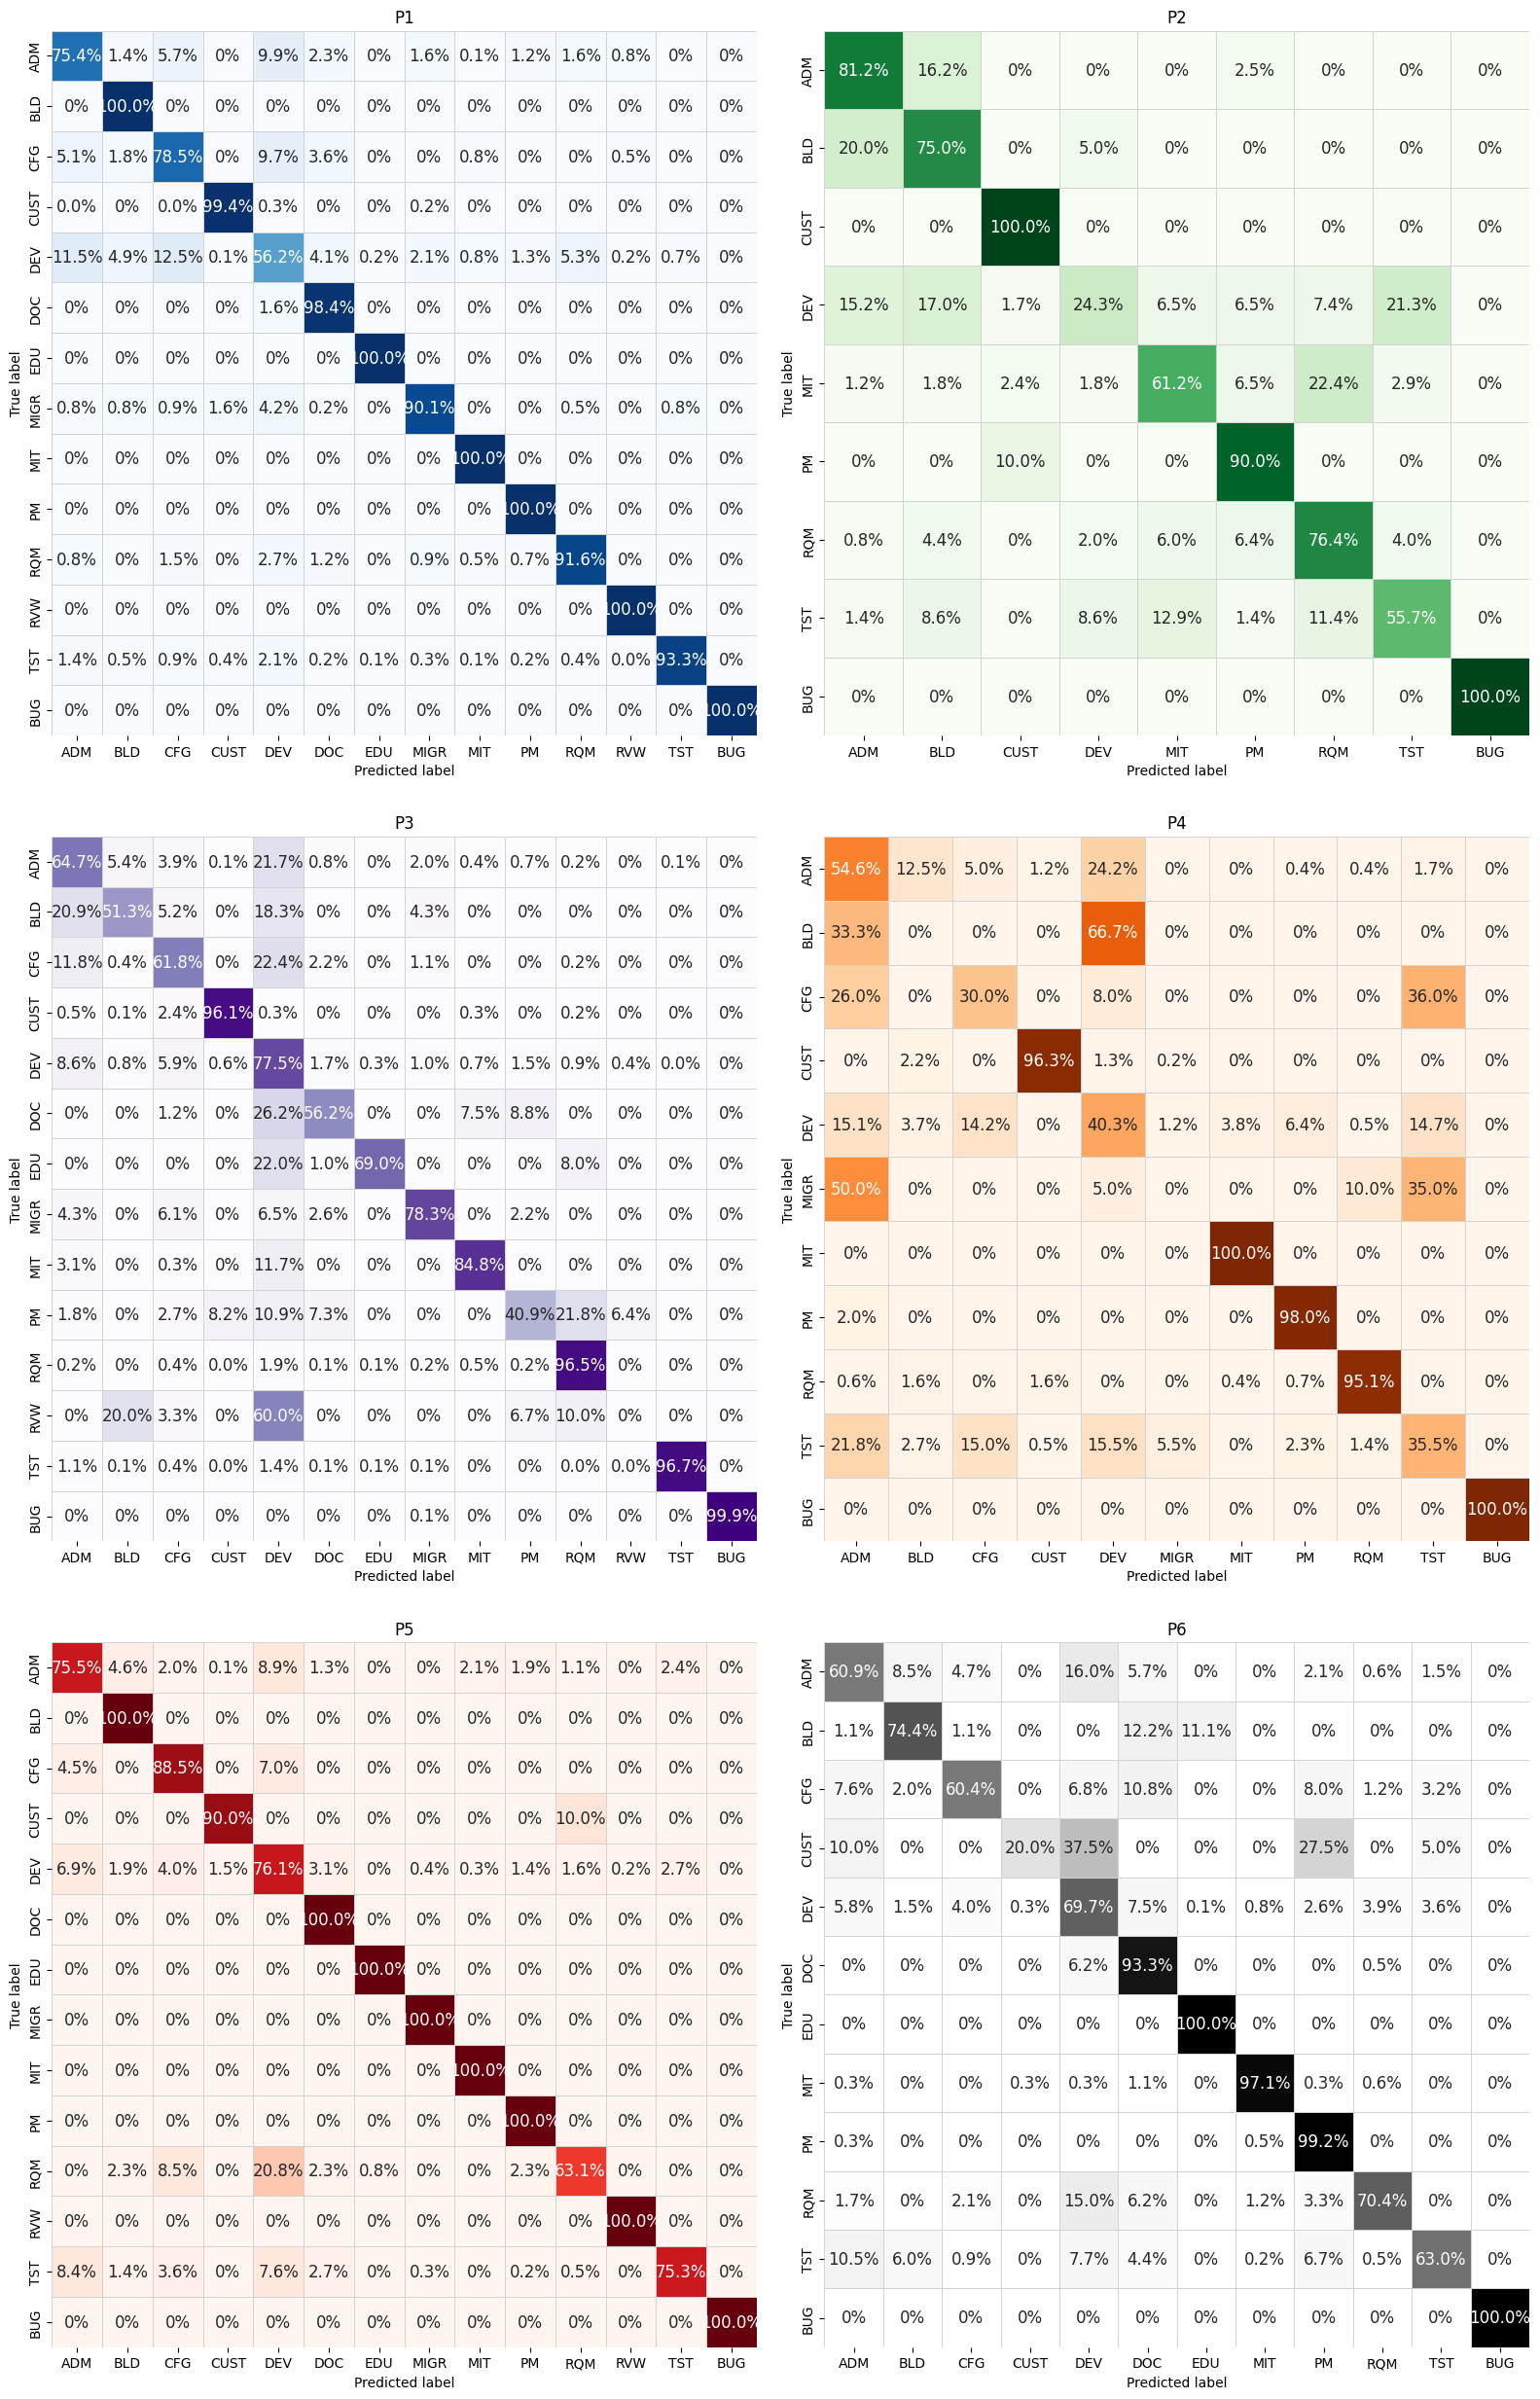

In [33]:
figsize=(16,25)
fig, axis = plt.subplots(3, 2, figsize=figsize)

axis = axis.reshape(-1)

for i, project in enumerate(result.keys()):
    cf_matrix = sum(result[project]['cnf'])
    classes=[v for k,v in result[project]['class_mappings'].items()]
    cmap=cmaps[project]
    
    cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    perc_labs = ["{0:.1%}".format(value) if value >0 else "0%" for value in cmn.flatten()]

    #group_counts = ["{0:0.0f}\n".format(value) if value > 0 else "" for value in cf_matrix.flatten()]
        
    #box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,perc_labs)]
    
    box_labels = perc_labs
    box_labels = np.asarray(box_labels).reshape(cmn.shape[0],cmn.shape[1])
    
    ax = axis[i]
    
    sns.heatmap(cmn, annot=box_labels, fmt='', 
                annot_kws={"fontsize":12},
                xticklabels=classes, 
                yticklabels=classes,
            cmap=cmap,
            linecolor='lightgray', linewidths=0.5,
            square=True,
            cbar=False,
            vmin=0, vmax=1, ax=ax)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(project)

plt.tight_layout()
plt.savefig("cnf-with-db.pdf")
plt.show()
plt.close() 


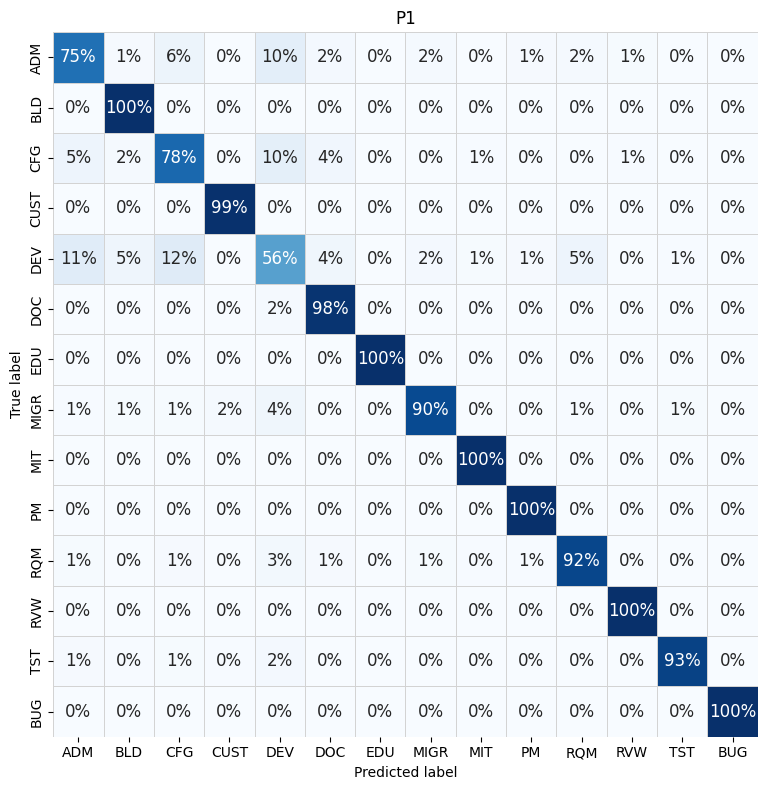

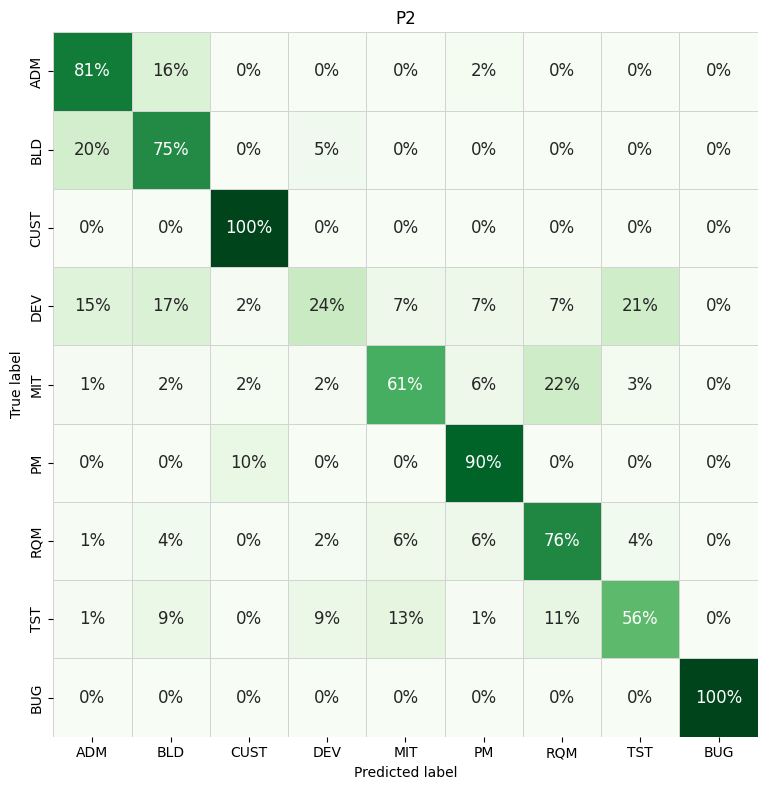

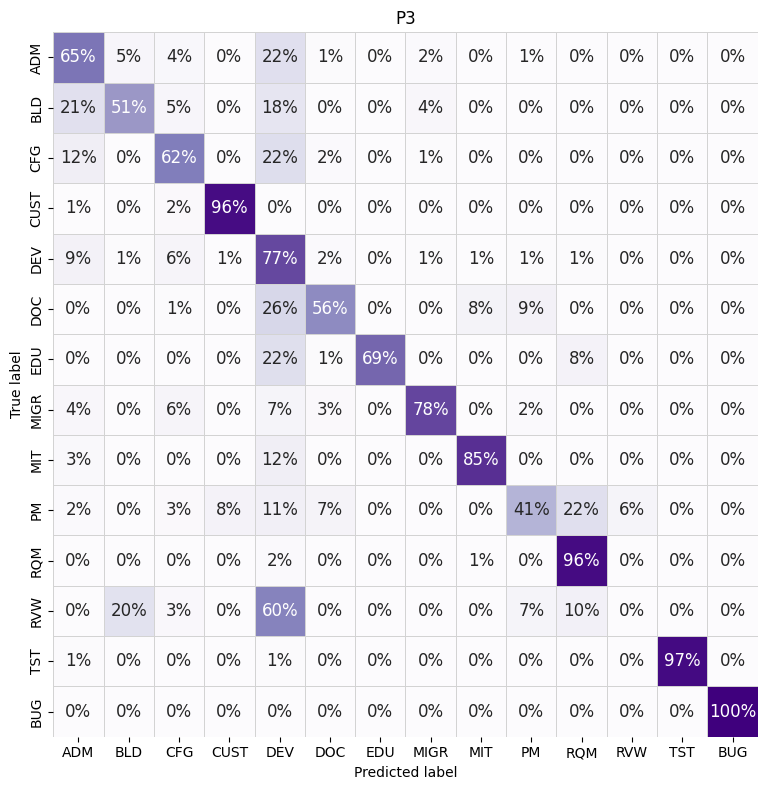

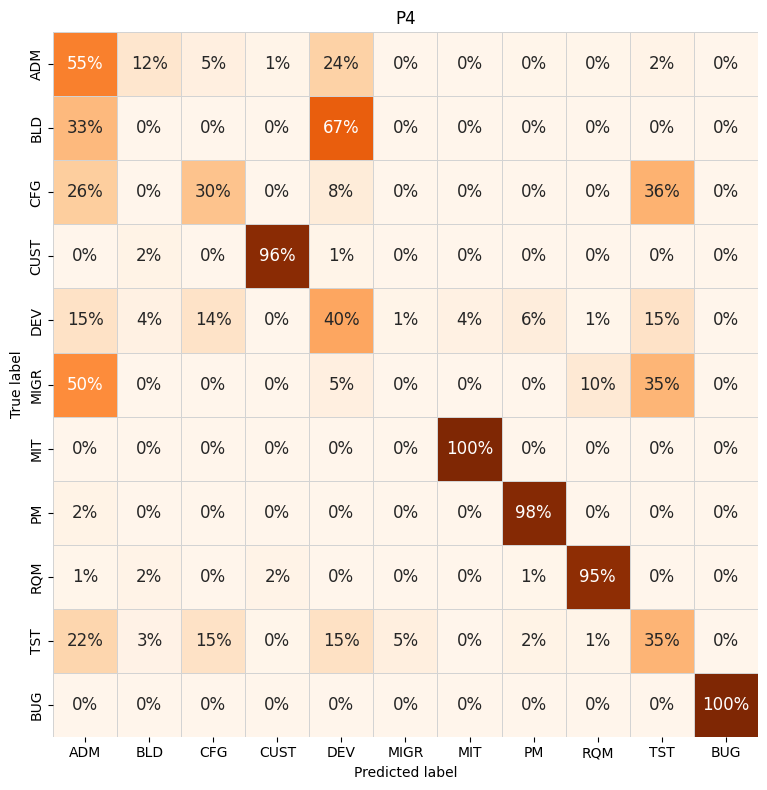

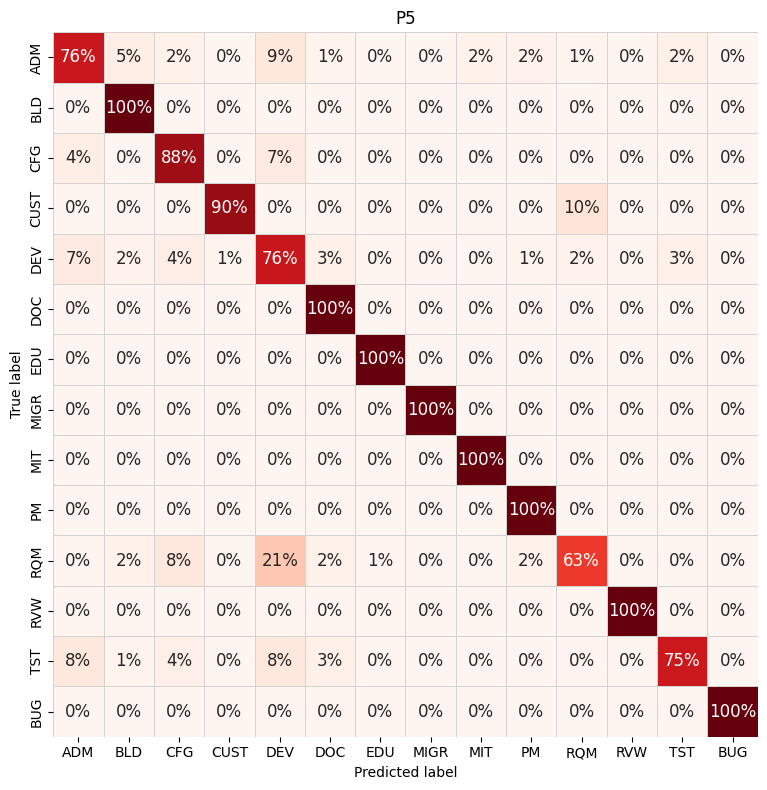

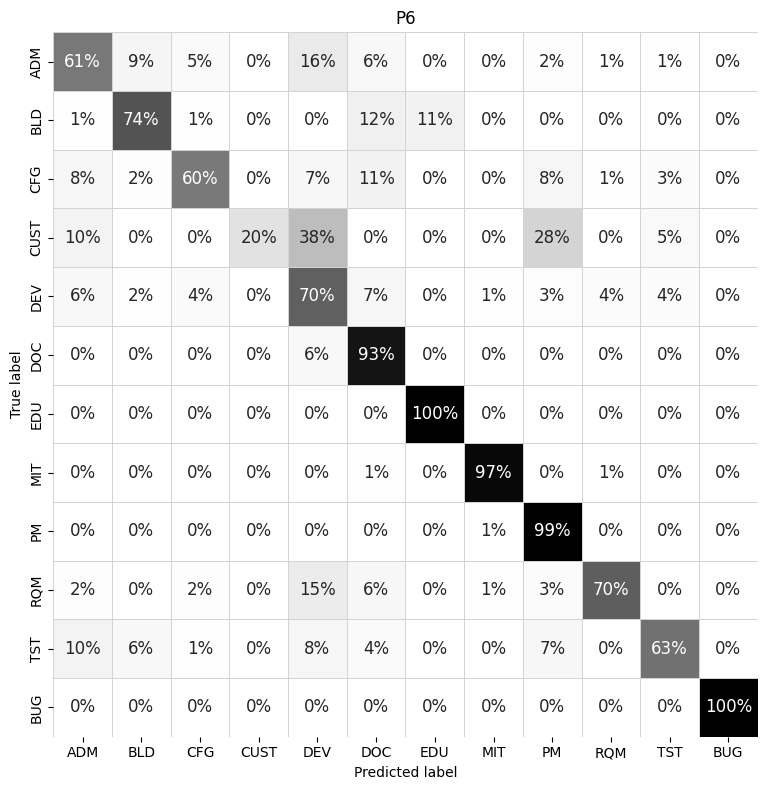

In [54]:
# for i, project in enumerate(result.keys()):
#     cnf_matrix = sum(result[project]['cnf'])
#     plot_confusion_matrix(cnf_matrix, classes=[v for k,v in result[project]['class_mappings'].items()], 
#                           cm_path=f"{project}-cnf.pdf", figsize=(8,8), cmap=cmaps[project], counts_zero=False)


for i, project in enumerate(result.keys()):
    figsize=(8,8)
    fig, ax = plt.subplots(figsize=figsize)
    cf_matrix = sum(result[project]['cnf'])
    classes=[v for k,v in result[project]['class_mappings'].items()]
    cmap=cmaps[project]
    
    cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    perc_labs = ["{0:.0%}".format(value) if value >0 else "0%" for value in cmn.flatten()]

    #group_counts = ["{0:0.0f}\n".format(value) if value > 0 else "" for value in cf_matrix.flatten()]
        
    #box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,perc_labs)]
    
    box_labels = perc_labs
    box_labels = np.asarray(box_labels).reshape(cmn.shape[0],cmn.shape[1])
    
    sns.heatmap(cmn, annot=box_labels, fmt='', 
                annot_kws={"fontsize":12},
                xticklabels=classes, 
                yticklabels=classes,
            cmap=cmap,
            linecolor='lightgray', linewidths=0.5,
            square=True,
            cbar=False,
            vmin=0, vmax=1, ax=ax)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(project)

    plt.tight_layout()
    plt.savefig(f"{project}-cnf.pdf")
    plt.show()
    plt.close() 



In [59]:
acc_avg = rec_avg = prec_avg = f1_avg = mcc_avg = 0

print("Project & Accuracy & (macro) Recall & (macro) Precision & (macro) F1-score & MCC \\\\ \\hline")

for project in result:
    r = result[project]
    acc = np.mean(r['acc'])
    acc_sd = np.std(r['acc'])
    prec = np.mean(r['prec'])
    prec_sd = np.std(r['prec'])
    rec = np.mean(r['rec'])
    rec_sd = np.std(r['rec'])
    f1 = np.mean(r['fscore'])
    f1_sd = np.std(r['fscore'])
    mcc = np.mean(r['mcc'])
    mcc_sd = np.std(r['mcc'])

    print(f"{project} & {acc:.2f} $\pm${acc_sd:.2f} & {rec:.2f} $\pm${rec_sd:.2f} & {prec:.2f} $\pm${prec_sd:.2f} & {f1:.2f} $\pm${f1_sd:.2f} & {mcc:.2f} $\pm${mcc_sd:.2f} \\\\ \\hline")

    acc_avg += acc
    prec_avg += prec
    rec_avg += rec
    f1_avg += f1
    mcc_avg += mcc

acc_avg /= 6
prec_avg /= 6
rec_avg /= 6
f1_avg /= 6
mcc_avg /= 6
print(f"Mean & {acc_avg:.2f} & {rec_avg:.2f} & {prec_avg:.2f} & {f1_avg:.2f} & {mcc_avg:.2f} \\\\")

Project & Accuracy & (macro) Recall & (macro) Precision & (macro) F1-score & MCC \\ \hline
P1 & 0.89 $\pm$0.00 & 0.92 $\pm$0.00 & 0.69 $\pm$0.01 & 0.75 $\pm$0.00 & 0.87 $\pm$0.00 \\ \hline
P2 & 0.78 $\pm$0.02 & 0.74 $\pm$0.03 & 0.64 $\pm$0.02 & 0.64 $\pm$0.03 & 0.73 $\pm$0.02 \\ \hline
P3 & 0.91 $\pm$0.00 & 0.70 $\pm$0.01 & 0.61 $\pm$0.01 & 0.64 $\pm$0.01 & 0.88 $\pm$0.00 \\ \hline
P4 & 0.80 $\pm$0.01 & 0.59 $\pm$0.02 & 0.53 $\pm$0.01 & 0.54 $\pm$0.01 & 0.76 $\pm$0.01 \\ \hline
P5 & 0.79 $\pm$0.00 & 0.91 $\pm$0.01 & 0.56 $\pm$0.02 & 0.65 $\pm$0.01 & 0.68 $\pm$0.01 \\ \hline
P6 & 0.76 $\pm$0.01 & 0.76 $\pm$0.01 & 0.59 $\pm$0.02 & 0.64 $\pm$0.01 & 0.69 $\pm$0.01 \\ \hline
Mean & 0.82 & 0.77 & 0.60 & 0.64 & 0.77 \\


## Train classifier on all data

In [44]:
projects_data_df = pd.DataFrame()

for dataset_name in datasets:
    dataset = datasets[dataset_name]
    for project, repo in list(dataset.items()):
        data_path = f"{datasets_path}/{repo}.csv"
        print(f'- loading features from file "{data_path}"')
        p_emb_df = pd.read_csv(data_path, sep='$')
        p_emb_df = p_emb_df[(p_emb_df["class_value"].notnull()) & (p_emb_df["class_value"] != 0)]
        projects_data_df = pd.concat([projects_data_df, p_emb_df])

- loading features from file "../Data/P1-g4-c-emb.csv"
- loading features from file "../Data/P2-g4-c-emb.csv"
- loading features from file "../Data/P3-g4-c-emb.csv"
- loading features from file "../Data/P4-g4-c-emb.csv"
- loading features from file "../Data/P5-g4-c-emb.csv"
- loading features from file "../Data/P6-g4-c-emb.csv"


In [36]:
X = projects_data_df.copy()
class_mappings = X[['class_value', 'class_name']].drop_duplicates().sort_values("class_value").set_index("class_value").to_dict()['class_name']
y = copy.deepcopy(X["class_value"].astype('int64'))
X.drop(['id', 'class_name', 'class_value', 'contents'], axis='columns', inplace=True)

le = LabelEncoder()
y = le.fit_transform(y)

In [37]:
model = XGBClassifier(500, max_depth=3, objective="multi:softmax", device="gpu")
model.fit(X, y, sample_weight=compute_sample_weight("balanced", y))

/home/user/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [38]:
model.save_model("xgboost-projects-only.json")

In [59]:
transfer_df = base_df.copy()

X = projects_data_df.copy()
class_mappings = X[['class_value', 'class_name']].drop_duplicates().sort_values("class_value").set_index("class_value").to_dict()['class_name']
        
missing_cols = set(X.columns.tolist()) - set(transfer_df.columns.tolist())
for miss_col in missing_cols:
    transfer_df[miss_col] = [0] * transfer_df.shape[0]
transfer_df = transfer_df[(transfer_df["class_value"].notnull()) & (transfer_df["class_value"] != 0)]

In [60]:
all_data_df = pd.concat([projects_data_df, transfer_df])

In [61]:
X = all_data_df.copy()
class_mappings = X[['class_value', 'class_name']].drop_duplicates().sort_values("class_value").set_index("class_value").to_dict()['class_name']
y = copy.deepcopy(X["class_value"].astype('int64'))
X.drop(['id', 'class_name', 'class_value', 'contents'], axis='columns', inplace=True)

le = LabelEncoder()
y = le.fit_transform(y)

In [64]:
model = XGBClassifier(500, max_depth=3, objective="multi:softmax", device="gpu")
model.fit(X, y, sample_weight=compute_sample_weight("balanced", y))

/home/user/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [65]:
model.save_model("xgboost-all-data.json")